In [1]:
# initiation 11/12/2023

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-white')

# Simulating A Whole Block's Decision Process

## 1. Setting the Stimuli

For convenience, we will use the same stimuli in a participant's certain block.

We can use this subject's perceptual performance to simulate the decision process.


In [2]:
# load data
import dill
with open('all_data.pkl', 'rb') as f:
    all_data = dill.load(f)

test_block_prev =  all_data[3][10]
test_block  =  all_data[3][11]

# Contrust Stimuli Sample
Contrasts = []
Contrasts.append(test_block_prev['ContrastSeq'].values[-1])
Contrasts += list(test_block['ContrastSeq'].values[1:])
StimSeq = list(test_block['StimSeq'].values)
ProbeOriRight = list(test_block['ProbeOriRight'].values)
ProbeOriLeft = list(test_block['ProbeOriLeft'].values)

Block_data = pd.DataFrame({'Contrast':Contrasts, 'StimSeq':StimSeq, 'ProbeOriRight':ProbeOriRight, 'ProbeOriLeft':ProbeOriLeft})
Block_data.head()

,Contrast,StimSeq,ProbeOriRight,ProbeOriLeft
0,0.048323,45,45,-45
1,0.051662,-45,45,-45
2,0.050036,-45,-45,45
3,0.054548,45,-45,45
4,0.053140,45,-45,45


Also, we extract the response section for validation.

In [3]:
# Extract Responses
RespOri = list(test_block['RespOri'].values)
RespLorR = list(test_block['RespLorR'].values)
Accuracy = list(test_block['Accuracy'].values)
Response_test_block = pd.DataFrame({'RespOri':RespOri, 'RespLorR':RespLorR, 'Accuracy':Accuracy})
Response_test_block.head()

,RespOri,RespLorR,Accuracy
0,45,1,1
1,45,1,0
2,-45,1,1
3,-45,1,0
4,45,-1,1


## 2. Baseline model
In this section, the particpants should make a perceptual decision based on the stimuli.

First, we assume all our stimuli are presented with the same difficulty, i.e., the accuracy of the correct judgement should always be 0.75.

Then, we can see if all predicted choices are correct.

In [20]:
np.random.seed(614)
sample_times = 100
trialnum = len(Contrasts)

Pred_Data_Corr = []
Pred_Acc = []
data_accuracy = test_block['Accuracy'].values

# loop through trials
for iSample in range(sample_times):
    Response = pd.DataFrame(columns=['RespOri', 'RespLorR', 'Accuracy'], index=range(50))
    for iTrial in range(trialnum):
        # 0.75 probability of percepting the correct orientation
        if np.random.rand() < 0.75:
            Response.loc[iTrial, 'Accuracy'] = 1
            Response.loc[iTrial, 'RespOri'] = Block_data.loc[iTrial, 'StimSeq']
            Response.loc[iTrial, 'RespLorR'] = Block_data.loc[iTrial, 'ProbeOriRight'] / Block_data.loc[iTrial, 'StimSeq']
        else:
            Response.loc[iTrial, 'Accuracy'] = 0
            Response.loc[iTrial, 'RespOri'] = Block_data.loc[iTrial, 'StimSeq'] * (-1)
            Response.loc[iTrial, 'RespLorR'] = Block_data.loc[iTrial, 'ProbeOriLeft'] / Block_data.loc[iTrial, 'StimSeq']

    # see if allignment with the data
    pred_accuracy = Response['Accuracy'].values
    Pred_Data_Corr.append(np.corrcoef(list(pred_accuracy), list(data_accuracy))[0, 1])
    Pred_Acc.append(np.sum(pred_accuracy == data_accuracy) / len(pred_accuracy))

print('Correlation with data: ', np.mean(Pred_Data_Corr), ' +/- ', np.std(Pred_Data_Corr))
print('Accuracy with data: ', np.mean(Pred_Acc), ' +/- ', np.std(Pred_Acc))

Correlation with data:  -0.004530707379479474  +/-  0.14206594955063118
Accuracy with data:  0.5914  +/-  0.059008812901125196


Of course, this model is awful, but it is a good start.

The baseline here is too simple to be true, at least we have to infer the accuracy based on current trial's Contrast.

## 3. Probabilistic Choice Model
Just like in the SD_ProbChoice.ipynb[SD_ProbChoice.ipynb], we can fit a logit function for the participant's probability of forming a Clockwise percept.

Then, we use this as the flipcoin probability to simulate the participant's choice.

In [30]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def logit_fit(subject_data, rep_times = 10):
    for iB in range(len(subject_data)):
        block_data = subject_data[iB].copy()
        block_data['ContrastSeq'] = normalize(block_data['ContrastSeq'])
        Curr_resp = block_data['RespOri'] / 45
        next_block_first = block_data['ContrastSeq'].values[-1]
        Curr_Sen = block_data['ContrastSeq'].shift(1) * (block_data['StimSeq'] / 45)
        test_regression = pd.DataFrame({'Curr_Sen': Curr_Sen, 'Curr_resp': Curr_resp, 'Constant': 1})
        if iB != 0:
            test_regression.iloc[0, 0] = next_block_first * (block_data['StimSeq'].values[0] / 45)
            
        test_regression['Curr_resp'].replace(-1, 0, inplace=True)
        test_regression = test_regression.dropna()
        if iB == 0:
            temp_data = test_regression
        else:
            temp_data = pd.concat([temp_data, test_regression], ignore_index=True)

    # Logistic regression
    import statsmodels.api as sm
    temp_logit = sm.Logit(temp_data['Curr_resp'], temp_data[['Curr_Sen', 'Constant']])
    temp_result = temp_logit.fit(disp = False, iter = 100)
    logit_params = temp_result.params
    print(temp_result.summary2())
    return logit_params

# fit the model
logit_params = logit_fit(all_data[3])

def prob_cw(x, logit_params):
    return special.expit(logit_params[0] * x + logit_params[1])


                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.224     
Dependent Variable: Curr_resp        AIC:              1062.5759 
Date:               2023-12-12 10:58 BIC:              1072.3894 
No. Observations:   999              Log-Likelihood:   -529.29   
Df Model:           1                LL-Null:          -681.89   
Df Residuals:       997              LLR p-value:      2.4120e-68
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Curr_Sen     2.1917     0.1452   15.0930   0.0000   1.9071   2.4764
Constant     0.4045     0.0768    5.2686   0.0000   0.2540   0.5549



/Users/abel/miniconda3/envs/pymc_env/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol. The list of unsupported keyword arguments passed include: iter. After release 0.14, this will raise.
  warnings.warn(


In [36]:
np.random.seed(614)

sample_times = 50

Pred_Data_Corr = []
Pred_Acc = []
test_block['ContrastSeq'] = normalize(test_block['ContrastSeq'])

# loop through trials
for iSample in range(sample_times):
    Response = pd.DataFrame(columns=['RespOri', 'RespLorR', 'Accuracy'], index=range(50))
    for iTrial in range(trialnum):
        
        # probability of percepting the clockwise, derived from the logistic regression
        if np.random.rand() < prob_cw(test_block.loc[iTrial, 'ContrastSeq'], logit_params):
            Response.loc[iTrial, 'RespOri'] = 45
        else:
            Response.loc[iTrial, 'RespOri'] = -45
    
    Response['RespLorR'] = Response['RespOri'] / test_block['ProbeOriRight']
    Response['Accuracy'] = (Response['RespOri'] == test_block['StimSeq'])
    Response['Accuracy'].replace(False, 0, inplace=True)
    Response['Accuracy'].replace(True, 1, inplace=True)
    
    #see if allignment with the data
    pred_accuracy = Response['Accuracy'].values
    data_accuracy = test_block['Accuracy'].values
    Pred_Data_Corr.append(np.corrcoef(pred_accuracy, data_accuracy)[0, 1])
    Pred_Acc.append(np.sum(pred_accuracy == data_accuracy) / len(pred_accuracy))

print('Correlation with data: ', np.mean(Pred_Data_Corr), ' +/- ', np.std(Pred_Data_Corr))
print('Congruence with data: ', np.mean(Pred_Acc), ' +/- ', np.std(Pred_Acc))

Correlation with data:  0.12035370712791217  +/-  0.11002920635830442
Congruence with data:  0.554  +/-  0.056178287620752554


## 4. PCM with Weibull Function

In [63]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def Weibull(I, a, b, pg, pl):
    """
    Compute the value of the psychometric curve based on the fomula given parameters and stimulus intensity.
    
    Inputs:
        I (float): Stimulus intensity.
        a (float): Bias parameter.
        b (float): Slope parameter.
        pg (float): Guess rate.
        pl (float): Lapse rate.
        
    Returns:
        float: The probability of detecting the stimulus (c_t=1) given the stimulus intensity I.
    """
    return pg + (1 - pg - pl) / (1 + np.exp(b * (a - I)))

def nlog_likelihood(params, I, c):
    """
    Compute the log likelihood of the data given the model parameters.
    
    Inputs:
        params (list): The model parameters.
        I (numpy.ndarray): The stimulus intensity.
        c (numpy.ndarray): The response.
        
    Returns:
        float: The log likelihood.
    """
    a, b, pg, pl = params
    Prob = Weibull(I, a, b, pg, pl)
    Prob = np.clip(Prob, 0.01, 0.99) # clip the probability to avoid numerical error
    log_likelihood = np.sum(c * np.log(Prob) + (1 - c) * np.log(1 - Prob)) # log likelihood of the data given the model parameters
    return -log_likelihood

def weibull_fit(subject_data, rep_times = 10):
    for iB in range(len(subject_data)):
        block_data = subject_data[iB].copy()
        block_data['ContrastSeq'] = normalize(block_data['ContrastSeq'])
        Curr_resp = block_data['RespOri'] / 45
        next_block_first = block_data['ContrastSeq'].values[-1]
        Curr_Sen = block_data['ContrastSeq'].shift(1) * (block_data['StimSeq'] / 45)
        test_regression = pd.DataFrame({'Curr_Sen': Curr_Sen, 'Curr_resp': Curr_resp, 'Constant': 1})
        if iB != 0:
            test_regression.iloc[0, 0] = next_block_first * (block_data['StimSeq'].values[0] / 45)
            
        test_regression['Curr_resp'].replace(-1, 0, inplace=True)
        test_regression = test_regression.dropna()
        if iB == 0:
            temp_data = test_regression
        else:
            temp_data = pd.concat([temp_data, test_regression], ignore_index=True)
    
    # Weibull regression
    fitted_params = []
    args=(temp_data['Curr_Sen'], temp_data['Curr_resp'])
    LB = [1e-4, 1e-4, 1e-4, 1e-4];
    UB = [1, 1e2, 1, 1];

    for iRep in range(rep_times):
        [a0] = np.random.uniform(1e-4, 1, 1)
        [b0] = np.random.uniform(1e-4, 1e2, 1)
        [pg0, pl0] = np.random.uniform(1e-4, 1, 2)
        x0 = [a0, b0, pg0, pl0];
        xopt = constrNMPy.constrNM(nlog_likelihood, x0, LB, UB, args=args, full_output=True)
        fitted_params.append(xopt['xopt'])

    model_params_est = np.mean(fitted_params, axis=0)
    return model_params_est

In [69]:
np.random.seed(614)

sample_times = 50

Pred_Data_Corr = []
Pred_Acc = []
test_block['ContrastSeq'] = normalize(test_block['ContrastSeq'])
params = weibull_fit(all_data[3])

# loop through trials
for iSample in range(sample_times):
    Response = pd.DataFrame(columns=['RespOri', 'RespLorR', 'Accuracy'], index=range(50))
    for iTrial in range(trialnum):
        
        # probability of percepting the clockwise, derived from the logistic regression
        if np.random.rand() < Weibull(test_block.loc[iTrial, 'ContrastSeq'], params[0], params[1], params[2], params[3]):
            Response.loc[iTrial, 'RespOri'] = 45
        else:
            Response.loc[iTrial, 'RespOri'] = -45
    
    Response['RespLorR'] = Response['RespOri'] / test_block['ProbeOriRight']
    Response['Accuracy'] = (Response['RespOri'] == test_block['StimSeq'])
    Response['Accuracy'].replace(False, 0, inplace=True)
    Response['Accuracy'].replace(True, 1, inplace=True)
    
    #see if allignment with the data
    pred_accuracy = Response['Accuracy'].values
    data_accuracy = test_block['Accuracy'].values
    Pred_Data_Corr.append(np.corrcoef(pred_accuracy, data_accuracy)[0, 1])
    Pred_Acc.append(np.sum(pred_accuracy == data_accuracy) / len(pred_accuracy))

print('Correlation with data: ', np.mean(Pred_Data_Corr), ' +/- ', np.std(Pred_Data_Corr))
print('Congruence with data: ', np.mean(Pred_Acc), ' +/- ', np.std(Pred_Acc))

Correlation with data:  0.13437559926268003  +/-  0.11772392453175826
Congruence with data:  0.556  +/-  0.0565685424949238


Apparantly, solely dependending on the **Current Sensory Evidence** is not enough to simulate the reported perceptual choices of the participant.

Moreover, we can see the congruence with original data is actually dropping in this simulation.

**Why?**

Since we have controlled the task difficulty at around the same level, we should believe that the likelihood is not affected much by the sensory evidence.

## Additionally, we see how is the contrast correlate with accuraies:

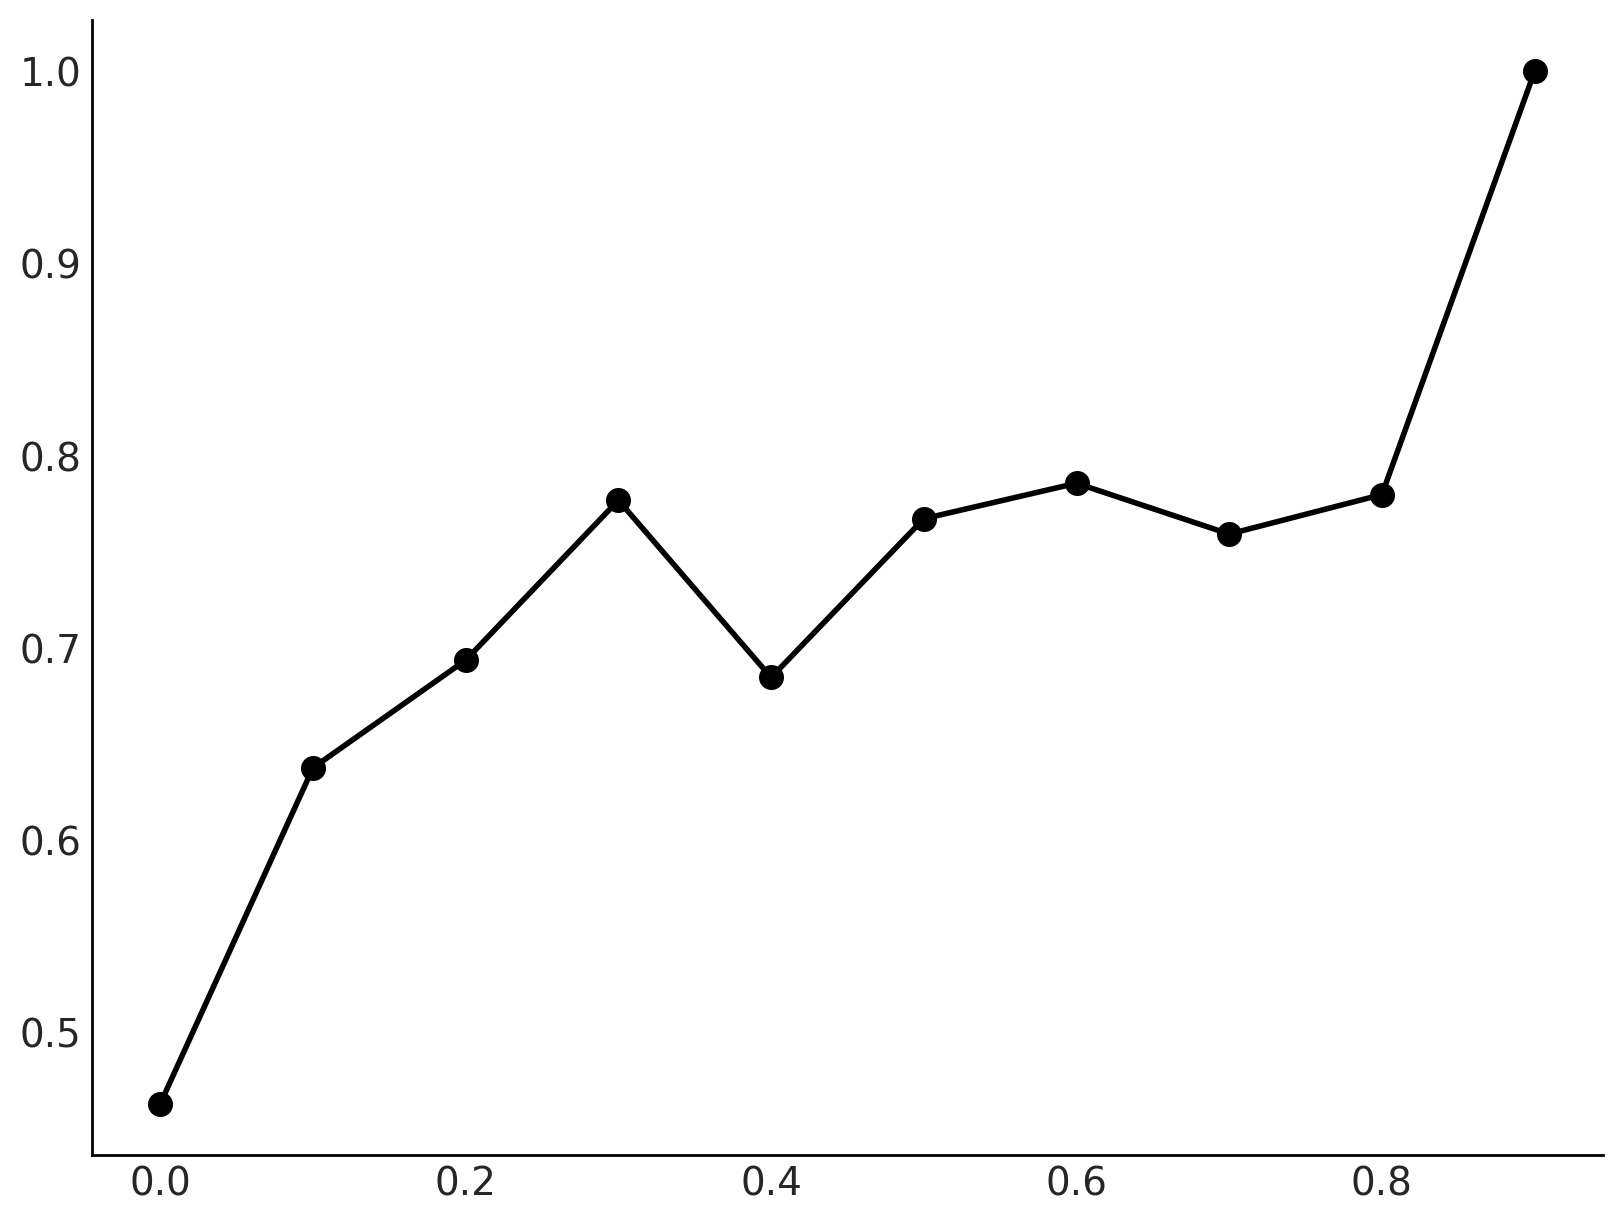

In [79]:
subject_data = all_data[3]

for iB in range(len(subject_data)):
    block_data = subject_data[iB].copy()
    block_data['ContrastSeq'] = normalize(block_data['ContrastSeq'])
    Curr_resp = block_data['RespOri'] / 45
    next_block_first = block_data['ContrastSeq'].values[-1]
    Curr_Sen = block_data['ContrastSeq'].shift(1) * (block_data['StimSeq'] / 45)
    Accuracy = block_data['Accuracy']
    test_regression = pd.DataFrame({'Curr_Sen': Curr_Sen, 'Curr_resp': Curr_resp, 'Accuracy': Accuracy, 'Constant': 1})
    if iB != 0:
        test_regression.iloc[0, 0] = next_block_first * (block_data['StimSeq'].values[0] / 45)
        
    test_regression['Curr_resp'].replace(-1, 0, inplace=True)
    test_regression = test_regression.dropna()
    if iB == 0:
        temp_data = test_regression
    else:
        temp_data = pd.concat([temp_data, test_regression], ignore_index=True)

# plot the accuracy distribution for different stimulus intensity
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
bins = np.linspace(0, 1, 11)
# calculate the mean accuracy for each stimulus intensity bin
temp_data['Curr_Sen'] = np.abs(temp_data['Curr_Sen'])
mean_acc = []
for iBin in range(len(bins) - 1):
    mean_acc.append(np.mean(temp_data[(temp_data['Curr_Sen'] >= bins[iBin]) & (temp_data['Curr_Sen'] < bins[iBin + 1])]['Accuracy']))

ax.plot(bins[:-1], mean_acc, 'o-', color='k', linewidth=2, markersize=8)


This trend is not accurately depicted from a Logistic function or a Weibull function.

Since the majority of the contrast level are set to be at 75% accuracy, the model will not be able to capture the trend.

Actually, if we can manage to illustrate a model that can ignore the effect of sensory evidence, we can surely demonstrate how serial dependence is affecting the participant's perceptual decision.

## 5 Adding History Effect

由于我们控制了刺激的对比度始终在阈值周围，保证难度相对恒定，所以我们假定对于两种不同的刺激的知觉 likelihood 始终都是 p = 0.75 的 Bernoulli 分布，而刺激历史构成 prior 影响后续的反应。